In [1]:
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [194]:
import fiona
import pyproj
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

from glob import glob
from shapely.geometry import Polygon

# Mapbox Access Token
mapbox_token = ""
mapbox_token = ""
px.set_mapbox_access_token(mapbox_token)

In [196]:
def read_kml(file_path):
    """
    Reads a KML file into a GeoDataFrame.
    """
    fiona.drvsupport.supported_drivers['KML'] = 'rw'

    if file_path.endswith('.kmz'):
        with zipfile.ZipFile(file_path, 'r') as kmz:
            kmz.extractall('temp_kml')
        file_path = glob('temp_kml/*.kml')[0]

    with fiona.open(file_path, driver='KML') as src:
        features = list(src)

    gdf = gpd.GeoDataFrame.from_features(features)

    if os.path.exists('temp_kml'):
        shutil.rmtree('temp_kml')

    return gdf, features

def calculate_area_hectares(geometry):
    """
    Calculates the area of a geometry in hectares.
    """
    proj = pyproj.Proj(proj="utm", zone=17, ellps="WGS84", south=True)

    utm_coords = [proj(*coord) for coord in geometry.exterior.coords]
    polygon = Polygon(utm_coords)
    area_sq_meters = polygon.area
    return area_sq_meters / 1e4

def calculate_polygon_area(file_path):
    """
    Reads a KML or KMZ file, calculates polygon areas in hectares, and returns a GeoDataFrame.
    """
    gdf, _ = read_kml(file_path)
    gdf["area_ha"] = gdf.geometry.apply(calculate_area_hectares)
    return gdf

In [203]:
kmls = glob("*kml")

kfile = kmls[0]
print(kfile)

# gdf, features = read_kml(kfile)
gdf = calculate_polygon_area(kfile)
gdf

CG0008-L1.kml


,geometry,Name,Description,area_ha
0,"POLYGON Z ((-80.23481 -2.37681 0, -80.23589 -2...",CG0008-L1,,92.787163


In [211]:
area = gdf['area_ha'].iloc[0]
area

92.78716254755598

In [164]:
data = gdf.geometry.iloc[0].boundary

lat_c, lon_c = list(data.centroid.coords)[0][::-1]
lat_c, lon_c

(-2.381794466690388, -80.23400517040022)

In [ ]:
coords = [(y, x) for (x, y, _) in list(data.coords)]
coords

In [168]:
styles = "open-street-map", "carto-positron", "carto-darkmatter", "stamen-terrain", "stamen-toner", "stamen-watercolor", "satellite"

styles2 = "satellite", "satellite-streets", "streets", "outdoors", "light", "dark", "navigation-preview-day", "navigation-preview-night", "navigation-guidance-day", "navigation-guidance-night"
len(styles2)

10

In [207]:
# Example Data for Polygons (Deforestation Polygons)
polygon_data = {
    "lat": [i[0] for i in coords],
    "lon": [i[1] for i in coords],
    "category": ["Deforestation"]*len(coords)
}

# Convert to DataFrame
polygon_df = pd.DataFrame(polygon_data)

# Center Coordinates
center_coordinates = {"lat": lat_c, "lon": lon_c}
center_coordinates

{'lat': -2.381794466690388, 'lon': -80.23400517040022}

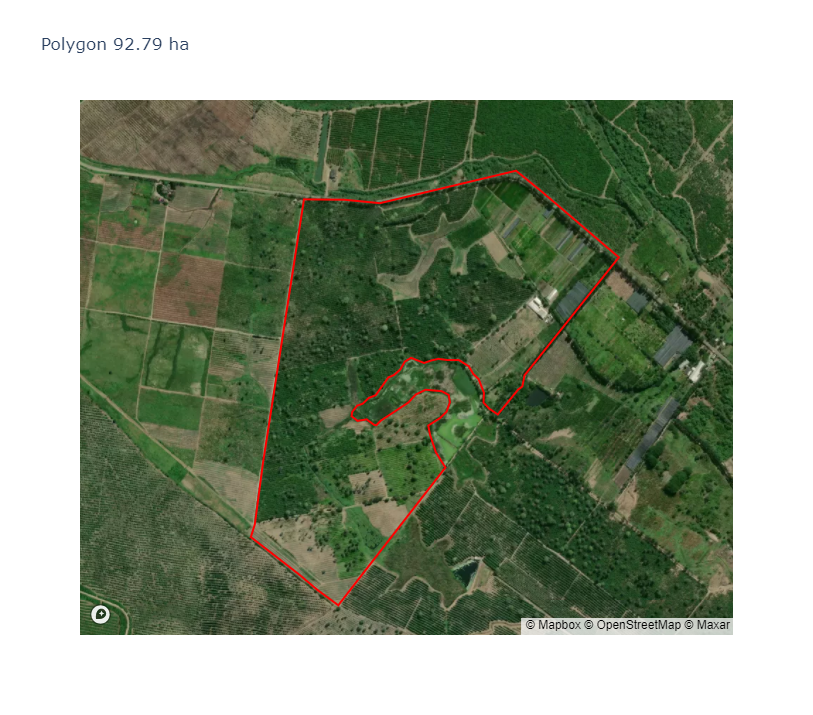

In [227]:
# Create the Figure
fig = go.Figure()

# Add the Polygon as a Line
fig.add_trace(
    go.Scattermapbox(
        lat=polygon_data["lat"],
        lon=polygon_data["lon"],
        mode="lines",  # Draw as lines
        line=dict(width=2, color="red"),  # Line style
        name="Deforestation Polygon"
    )
)

# Mapbox Settings
fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        style="satellite",  # Custom Style URL
        center=center_coordinates,
        zoom=14.5
    ),
    # title="Deforestation Polygon",
    title=f"Polygon {round(area, 2)} ha",
    width=1250,  # Set the width of the figure
    height=715   # Set the height of the figure
)

# Show the Map
fig.show()